# Decision Tree Classification - Uber Fare Prediction

## Algorithm Description

This notebook applies a **Decision Tree Classifier**, implemented from scratch in the custom-built `rice_ml` package, to predict whether an Uber ride results in a high fare (greater than $15). The model is based on recursive binary splits that minimize Gini impurity, forming a hierarchical structure of decisions.

We directly call the classifier via:

```python
from rice_ml.decision_tree import DecisionTree
```

A decision tree consists of internal decision nodes, which test specific feature values (e.g., distance, time, passenger count), and leaf nodes, which provide the final classification (high fare or low fare). The image below illustrates a simplified decision tree structure, where a series of binary conditions guide the decision process from the root node to the final outcome.


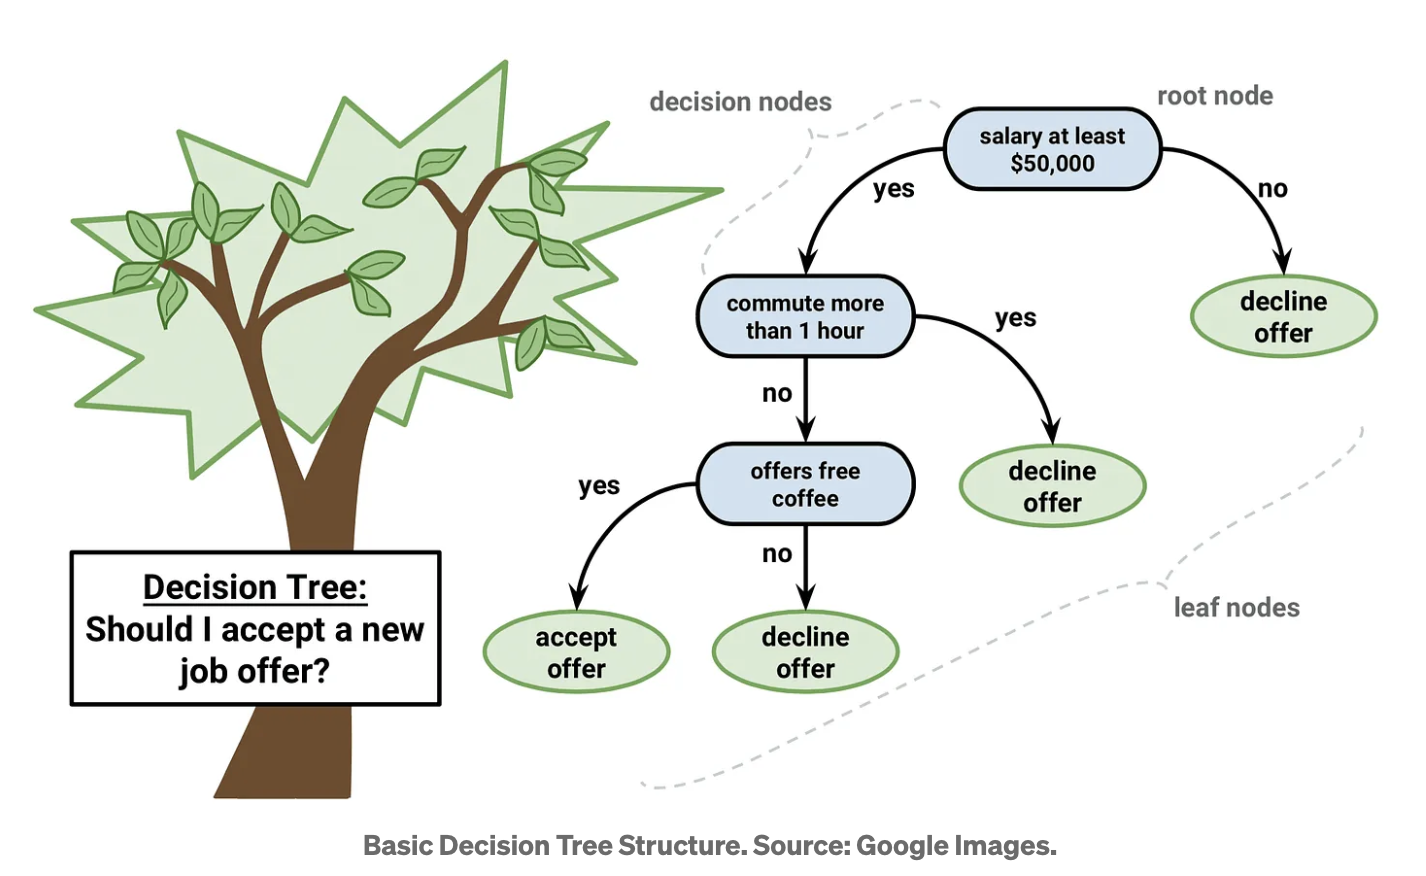

Each internal node represents a question (e.g., "Is the pickup time during rush hour?"), and each leaf node represents a classification outcome. In our model, the structure is learned directly from the data based on maximizing information gain (or minimizing impurity).


Cloning into 'INDE577_ML_Rice_2025'...
remote: Enumerating objects: 300, done.
remote: Counting objects: 100% (300/300), done.
remote: Compressing objects: 100% (233/233), done.
remote: Total 300 (delta 145), reused 156 (delta 60), pack-reused 0 (from 0)
Receiving objects: 100% (300/300), 10.85 MiB | 11.51 MiB/s, done.
Resolving deltas: 100% (145/145), done.
Mounted at /content/drive
=== Decision Tree Classification ===
Accuracy:  0.9310
Precision: 0.8811
Recall:    0.7079


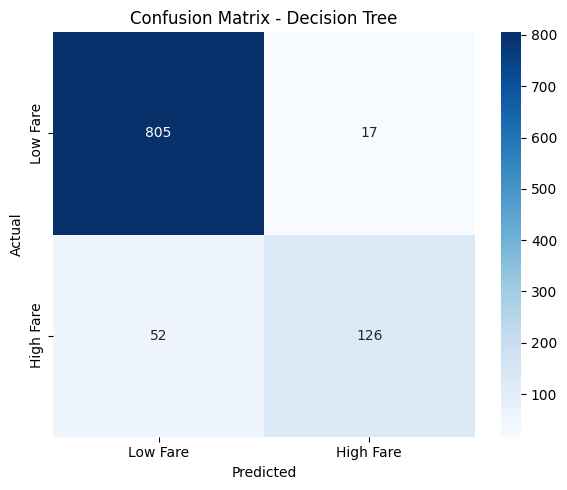

In [1]:
# Step 1: Clone GitHub repo and import decision tree model
!rm -rf INDE577_ML_Rice_2025
!git clone https://github.com/alicewang777/INDE577_ML_Rice_2025.git

import sys
sys.path.append('/content/INDE577_ML_Rice_2025')

from rice_ml.decision_tree import DecisionTree
from rice_ml.metrics import accuracy

# Step 2: Mount Drive and load dataset
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score

# Step 3: Load and preprocess Uber fare data
csv_path = "/content/drive/MyDrive/Colab Notebooks/ML_Rice_2025_Final_Project/uber.csv"
df = pd.read_csv(csv_path)

# Filter invalid coordinates
df = df[(df['pickup_longitude'] != 0) & (df['dropoff_longitude'] != 0)]
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')
df = df.dropna()
df = df[df['fare_amount'] < 100]

# Define binary label: High fare (1) if > $15
df['label'] = (df['fare_amount'] > 15).astype(int)
df = df.sample(n=5000, random_state=42)

# Step 4: Feature engineering
df['minute'] = df['pickup_datetime'].dt.minute
df['hour_exact'] = df['pickup_datetime'].dt.hour + df['minute'] / 60.0
df['dayofweek'] = df['pickup_datetime'].dt.dayofweek
df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
df['hour_exact_x_passenger'] = df['hour_exact'] * df['passenger_count']
df['manhattan_distance'] = (
    np.abs(df['pickup_longitude'] - df['dropoff_longitude']) +
    np.abs(df['pickup_latitude'] - df['dropoff_latitude'])
)

features = [
    'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
    'passenger_count', 'hour_exact', 'dayofweek', 'is_weekend',
    'hour_exact_x_passenger', 'manhattan_distance'
]

X_raw = df[features].values
y = df['label'].values

# Step 5: Scale features and split data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 6: Train decision tree model
tree_model = DecisionTree(max_depth=6, min_samples_split=10)
tree_model.fit(X_train, y_train)
y_pred = tree_model.predict(X_test)

# Step 7: Evaluate model performance
acc = accuracy(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)

print("=== Decision Tree Classification ===")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")

# Step 8: Visualize confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Low Fare", "High Fare"], yticklabels=["Low Fare", "High Fare"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Decision Tree")
plt.tight_layout()
plt.show()


### Model Interpretation: Decision Tree on Uber Fare Classification

The decision tree model achieves **93.1% overall accuracy**, correctly identifying most low-fare trips (TN = 805, FP = 17) and a meaningful portion of high-fare trips (TP = 126, FN = 52).

- **Precision (0.8811)** indicates that when the model predicts a trip is high fare, it is correct about 88% of the time.
- **Recall (0.7079)** suggests the model captures around 71% of all actual high-fare cases.
- The confusion matrix also reveals **strong true negative performance**, but some false negatives remain—potential high-fare trips classified as low.

This trade-off is common in imbalanced classification tasks. Nonetheless, the model demonstrates **strong generalization and interpretability**, making it a solid baseline for further improvement (e.g., via pruning or ensemble methods like Random Forests or Boosting).